In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from lcdb.db import LCDB
from lcdb.analysis.json import QueryAnchorValues, QueryMetricValuesFromAnchors
from lcdb.analysis.score import balanced_accuracy_from_confusion_matrix
import matplotlib.pyplot as plt

def extract_runtimes(info):
    runtime_anchor = []

    for child in info.get('children', []):
        if child['tag'] == 'build_curves':
            # extract anchor under build_curves
            for anchor in child.get('children', []):
                if anchor['tag'] == 'anchor':
                    # extract the training set size
                    anchor_value = anchor.get('metadata', {}).get('value')

                    # Initialize fit_time and predict_time as None
                    fit_time = None
                    predict_time = None

                    for runtime in anchor.get('children', []):
                        # extract the fit time
                        if runtime['tag'] == 'fit':
                            fit_time = runtime['timestamp_stop'] - runtime['timestamp_start']
                            
                        if runtime['tag'] == 'get_predictions': 
                            predict_time = runtime['timestamp_stop'] - runtime['timestamp_start']

                    # Only append if both fit_time and predict_time are found
                    if fit_time is not None and predict_time is not None:
                        runtime_anchor.append((anchor_value, fit_time, predict_time))

    return runtime_anchor


extract the anchor_value and compute the runtime

In [40]:
# workflow  = "lcdb.workflow.sklearn.LibLinearWorkflow"
# workflow  = "lcdb.workflow.sklearn.LibSVMWorkflow"
workflow  = "lcdb.workflow.sklearn.TreesEnsembleWorkflow"

openml_id = 3   # 3,6,11,12,14

db = LCDB().query(workflows=[workflow], openmlids=[openml_id])


runtime_df = {}
for index, df in tqdm(enumerate(db)): 
    ###### compute the runtime and extract the anchor_value
    expanded_rows = []
    # loop through each row in one df (random seed)
    for _, row in df.iterrows():
        extracted_data = extract_runtimes(row['m:json'])
        for data in extracted_data:
            new_row = row.copy()  
            new_row['anchor_value'] = data[0]
            new_row['fit_time'] = data[1]
            new_row['predict_time'] = data[2]
            expanded_rows.append(new_row)

    runtime_df[index] = pd.DataFrame(expanded_rows)

    # remove m:json
    # runtime_df[index] = runtime_df[index].drop(columns=['m:json'])
    # maintain runtime related value
    runtime_df[index] = runtime_df[index].loc[:, ['anchor_value', 'fit_time', 'predict_time']]
    # relabel the index, one curve in one setting is labeled as one index
    runtime_df[index]['hyperparam_setting_index'] = runtime_df[index].index.factorize()[0]


25it [01:28,  3.56s/it]


combine the dataframe in [anchor_value, fit_time, predict_time, hyperparam_setting_index, random_seed_combination]

In [41]:
dfs = []
for key, df in runtime_df.items():
    df_with_key = df.copy()
    df_with_key['random_seed_combination'] = key
    dfs.append(df_with_key)

combined_df = pd.concat(dfs, ignore_index=True)

plot

/tmp/ipykernel_739614/1717960611.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


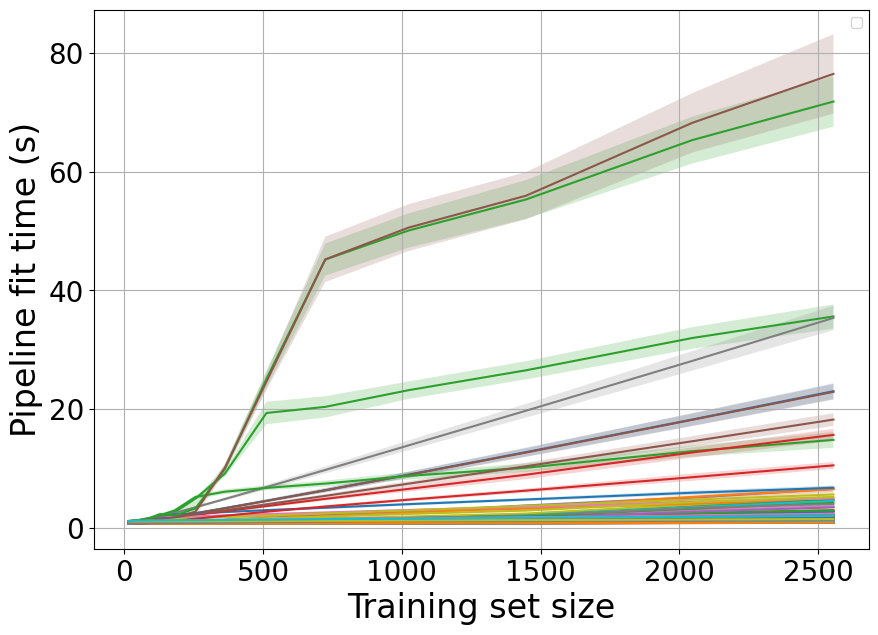

In [42]:
# get unique hyperparameter_setting_index values
hyperparameter_setting_indices = combined_df['hyperparam_setting_index'].unique()

plot_data = []
for index in hyperparameter_setting_indices:
    # extract data for the current hyperparameter_setting_index
    subset_df = combined_df[combined_df['hyperparam_setting_index'] == index]
    
    # compute the mean and standard deviation of fit_time for each anchor_value
    summary = subset_df.groupby('anchor_value')['fit_time'].agg(['mean', 'std']).reset_index()
    
    # add the computed summary to the plot_data list
    plot_data.append((summary, index))



plt.figure(figsize=(10, 7))
for summary, index in plot_data:
    plt.plot(summary['anchor_value'], summary['mean'])
    plt.fill_between(summary['anchor_value'], summary['mean'] - summary['std'], summary['mean'] + summary['std'], alpha=0.2)
plt.xlabel('Training set size',fontsize=24)
plt.ylabel('Pipeline fit time (s)',fontsize=24)
# plt.title('Pipeline fit time curves in 100 hyperparameter settings')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.grid(True)

plt.show()


/tmp/ipykernel_739614/3257147169.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


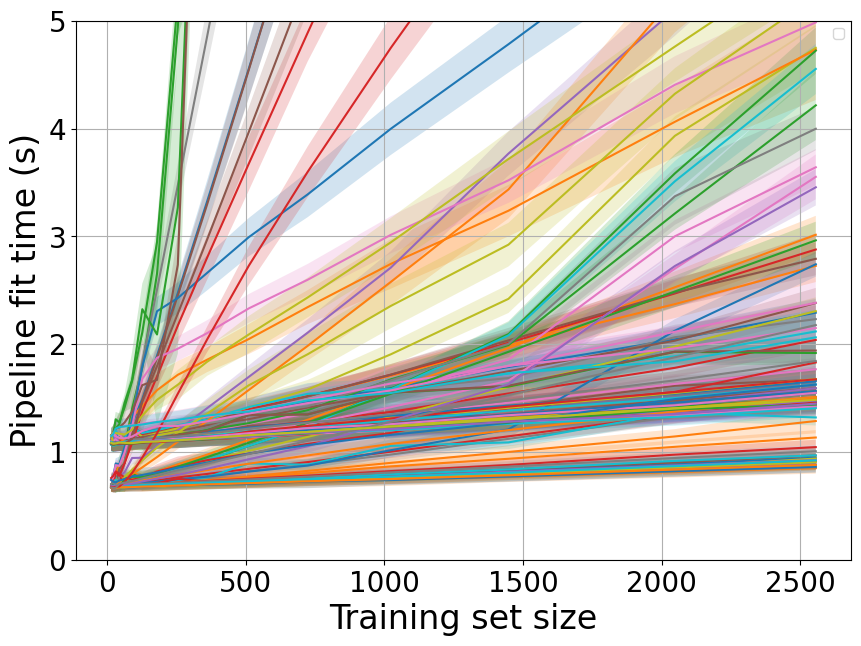

In [43]:
plt.figure(figsize=(10, 7))
for summary, index in plot_data:
    plt.plot(summary['anchor_value'], summary['mean'])
    plt.fill_between(summary['anchor_value'], summary['mean'] - summary['std'], summary['mean'] + summary['std'], alpha=0.2)

# set y axis scale
plt.ylim([0, 5])  

plt.xlabel('Training set size',fontsize=24)
plt.ylabel('Pipeline fit time (s)',fontsize=24)
# plt.title('Pipeline fit time curves in 100 hyperparameter settings')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.grid(True)

plt.show()